This walkthrough includes an example of a test run. The UV-Vis data and resulting files can be found within this directory.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import ADT_OT2_Analysis as AD

### Files and Formats

This analysis method will utilize 3 initial files:
1. UV-Vis calibration curve (.csv)
2. A "longform" data file (.csv)
3. A "shortform" data file (.csv)

The UV-Vis data should be formatted as such:

| C_uM | Abs_raw | Abs |
| --- | --- | --- |
| 0 |  |  |
| 5 |  |  |
| 10 |  |  |
| 15 |  |  |
| 20 |  |  |

where **C_uM** is concentration and **Abs** is the blank-corrected absorbance. The Abs_raw category is not necessary, but may be useful for record keeping purposes. 

The "longform" data file is for record-keeping (And may be useful for applications like altair that work better in that format). The file should be formatted as:

| Time | Hcell | Sample | Abs_raw | Abs |
| --- | --- | --- | ---| --- |
| 0 | H1_C1 | PES_P20G10_AB9_S1 | 1.1 | 1.07 |

Where all aliquots collected from H-cell 1, chamber 1 are recorded, then from H-cell 1, chamber 2, and so on. This keeps track of the metadata for each membrane sample, including which H-cell position it was tested in, the raw abs data, and corrected abs data. 

This file will be modified to include the conversion from abs to concentration, and the original undiluted dye concentration in the H-cells.

The "shortform" file is a reconfiguration of the abs data, essentially flipping the axis of the well plate. The sample well plate collects aliquots such that the H-cell compartments each have their own row, and samples are added by column. The shortform flips so that Time (hr) is the row, and each H-cell compartment has an associated column. 

| Time | H1_C1 | H1_C2 | H2_C1 | H2_C2 | H3_C1 | H3_C2 | H4_C1 | H4_C2 |
| --- | --- | --- | ---| --- | --- | --- | --- | --- |
| 0 | 1 | 0 | 1  | 0 | 1 | 0 | 1 | 0 |
| 4 | 0.9 | 0.1 | 0.88  | 0.12 | 0.95 | 0.05 | 0.91 | 0.09 | 

This file will be modified and eventually saved, with all calculations performed. 

### Variables

All experiment-specific variables needed.

The three files explained above (UV-Vis calibration curve, "longform" data, and "shortform" data) are saved within the "OT2_Data" folder. 

Example:
- UV-Vis calibration: `'OT2_Data/20250417_ot2_calibration_AO.csv'`
- longform file: `'OT2_Data/20250417_ot2_PES_P40G00_AO_long.csv'`
- shortform file: `'OT2_Data/20250417_ot2_PES_P40G00_AO_short.csv'`

Maintaining this naming convention allows the following cells to run with minimal need to edit.

In [3]:
# Testing Details
# Note: dye_sh is the shorthand used in the .csv file names (e.g., AO, BB)

Date = '20250505'
Membrane = 'P25G00'
Dye_name = 'Acid Orange 7'
dye_sh = 'AO' 
dilution_factor = 10

# Membrane sample names (in order of H1, H2, H3, H4)
# membrane_L is membrane thickness (in microns). Default is 110
H_cells = { }
 
H_cells['H1'] = {'sample':'S1', 'membrane_L': 120}
H_cells['H2'] = {'sample':'S2', 'membrane_L': 110}
H_cells['H3'] = {'sample':'S3', 'membrane_L': 110}
H_cells['H4'] = {'sample':'S4', 'membrane_L': 120}

# if using all 8 H-cells, simply add on to the dictionary above

In [4]:
#experiment_handle = '20250412_ot2_PES_P40G00_RB'
experiment_handle = Date + '_ot2_PES_' + Membrane + '_' + dye_sh

# Files to read
calibration_curve_csv = 'OT2_Data/'+ Date + '_ot2_calibration_' + dye_sh + '.csv'
longform_filename = 'OT2_Data/' + experiment_handle + '_long.csv'
shortform_filename = 'OT2_Data/' + experiment_handle + '_short.csv'

# What you want to name the files that will be saved
longform_save_name = 'Results/' + experiment_handle + '_metadata.csv'
full_df_save_name ='Results/' + experiment_handle + '.csv'

# Diffusion parameters
total_vol = 2.2e13 #(um^3)
area = np.pi*(16000/2)**2 #(um^2)

### Plotting parameters

The following cell is used to autofill certain kwargs when plotting results later on. Plot labels are generated from the data provided above.

**max_t**: total experimental time, used to determine the range of the x-axis

**dye**: preset colors to represent the dye options, primarily used for comparison plots.

The **color suites** are selections of hues that can be referenced using the variables.

In [5]:
# Labels for plot legends--no need to change these
plot_H1 = Membrane + ' ' + H_cells['H1']['sample']
plot_H2 = Membrane + ' ' + H_cells['H2']['sample']
plot_H3 = Membrane + ' ' + H_cells['H3']['sample']
plot_H4 = Membrane + ' ' + H_cells['H4']['sample']
plot_labels = [plot_H1, plot_H2, plot_H3, plot_H4]

# if using all 8 H-cells:
'''
plot_H5 = Membrane + ' ' + H_cells['H5']['sample']
plot_H6 = Membrane + ' ' + H_cells['H6']['sample']
plot_H7 = Membrane + ' ' + H_cells['H7']['sample']
plot_H8 = Membrane + ' ' + H_cells['H8']['sample']
plot_labels = [plot_H1, plot_H2, plot_H3, plot_H4,
               plot_H5, plot_H6, plot_H7, plot_H8]
'''

max_t = 66 #max time (hrs)

# Colors by dye type
rb = 'palevioletred'
mb = 'rebeccapurple'
bb = 'royalblue'
ao = 'darkorange'
contrast = 'dimgrey'
DT_suite = [rb, mb, bb, ao]

dye = ao

# comparison plot options
contrast_A = 'cornflowerblue'
contrast_B = 'forestgreen'
contrast_C = 'violet'

#colorblind suite
color_A = (0,0.306,0.920) #blue
color_B = (0,0.5,0) #green
color_C = (0.73,0.33,0.83) #fuschia
color_D = (0.88,0.55,0) #orange
CB_suite = [color_A, color_B, color_C, color_D]

# Original suite
OG_A = 'cornflowerblue'
OG_B = 'forestgreen'
OG_C = 'peru'
OG_D = 'palevioletred'
OG_suite = [OG_A, OG_B, OG_C, OG_D]

## Calibration Curve

typical abs vs concentration slope values for each dye (A = $\epsilon$ lC), to be used as a sanity check for the calibration curve:

| Dye | Abs | alternate |
| --- | --- | --- |
| BB | 0.069 | 0.0723 | 
| AO | 0.0135 |  |
| RB | 0.0589 | 0.058 |
| MB | 0.0327 | 0.035 |

In [6]:
#absorption coefficient dertermined from Calibration section
m, b = AD.absorptivity(calibration_curve_csv)
absorptivity = round(m,4)

print('absorptivity = ', absorptivity)

line of best fit:
y = 0.0132x + 0.009
absorptivity =  0.0132


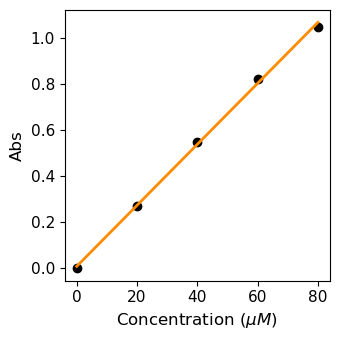

In [7]:
# plotting the calibration curve for a sanity check (optional)
calibration_curve_df = pd.read_csv(calibration_curve_csv)
X = calibration_curve_df['C_uM']
Y = calibration_curve_df['Abs']
yfit = [b + m * xi for xi in X]

fig, ax = plt.subplots(figsize=(3.5,3.5))

ax.plot(X, Y, ms=6, marker='o', linewidth=0, color='black')
ax.plot(X, yfit, linewidth=2, color = 'darkorange')
ax.set_xlabel(r'Concentration ($\mu M$)', fontsize=12)
ax.set_ylabel('Abs', fontsize=12)
ax.tick_params(labelsize=11)

plt.tight_layout()
plt.show();

## Analysis

### Part 1: Longform .csv

This function reads the longform file, uses the $\epsilon$ l value determined from the calibration curve to calculate sample concentration for each time step (`'C_sample'`), and back-calculates the original concentrations (pre-dilution) in the H-cells (`'C_original'`). The default concentration for these calculations is uM.

Saving the metadata file will save this modified df to the `Results/` folder, unless otherwise specified in the variables section above.

In [8]:
longform = AD.longform_record(longform_filename, absorptivity, dilution_factor)
longform

,Time,Hcell,Sample,Abs_raw,Abs,C_sample,C_original
0,0,H1_C1,PES_P25G00_AO_S1,1.111,1.080,81.8182,818.1818
1,6,H1_C1,PES_P25G00_AO_S1,0.998,0.965,73.1061,731.0606
2,12,H1_C1,PES_P25G00_AO_S1,0.918,0.886,67.1212,671.2121
3,18,H1_C1,PES_P25G00_AO_S1,0.863,0.830,62.8788,628.7879
4,24,H1_C1,PES_P25G00_AO_S1,0.806,0.774,58.6364,586.3636
...,...,...,...,...,...,...,...
91,42,H4_C2,PES_P25G00_AO_S4,0.368,0.336,25.4545,254.5455
92,48,H4_C2,PES_P25G00_AO_S4,0.396,0.363,27.5000,275.0000
93,54,H4_C2,PES_P25G00_AO_S4,0.420,0.387,29.3182,293.1818
94,60,H4_C2,PES_P25G00_AO_S4,0.448,0.415,31.4394,314.3939


### Save the metadata file:

In [ ]:
longform.to_csv(longform_save_name, index=False)

### Part 2: Shortform .csv (Concentrations, Averages, and Diffusion Coefficients)
This is where the shortform file is converted to a new df with the original dye concentrations (instead of UV-Vis absorbances)

The concentration data for each sample is then used to determine:
- Diffusion coefficients calculated at each time point per membrane sample
- overall diffusion coefficient for each individual sample, averaged over the given index range

In [11]:
full_df, D_aves = AD.data_calculations(shortform_filename, absorptivity, dilution_factor, 
                     total_vol, area, H_cells=H_cells, index_range=[1,2,3,4,5,6,7,8,9,10,11])

In [12]:
full_df

,Time,H1_C1,H1_C2,H2_C1,H2_C2,H3_C1,H3_C2,H4_C1,H4_C2,S1,S2,S3,S4
0,0,818.18,2.27,807.58,2.27,815.15,1.52,815.15,0.76,inf,inf,inf,inf
1,6,731.06,73.48,739.39,64.39,728.03,65.15,753.03,53.79,30.00,24.13,24.21,21.49
2,12,671.21,132.58,690.91,119.70,680.30,116.67,711.36,102.27,29.66,24.41,23.44,21.93
3,18,628.79,180.30,654.55,167.42,650.76,160.61,675.76,142.42,29.33,24.77,23.21,21.75
4,24,586.36,219.70,600.76,200.00,596.97,196.21,626.52,176.52,29.14,23.72,22.81,21.54
5,30,542.42,251.52,572.73,240.91,574.24,230.30,596.21,210.61,28.86,25.18,23.13,22.07
6,36,531.82,282.58,545.45,267.42,537.12,260.61,566.67,237.88,29.57,25.08,23.61,22.16
7,42,509.85,303.03,520.45,291.67,531.82,287.12,561.36,254.55,29.14,25.35,24.17,21.23
8,48,487.88,321.97,497.73,307.58,505.30,304.55,530.30,275.00,29.19,24.82,23.85,21.30
9,54,469.70,336.36,490.91,325.76,483.33,325.00,518.18,293.18,28.95,25.26,24.60,21.41


In [14]:
D_aves

,S1,S2,S3,S4
mean,29.3,24.9,23.8,21.7
std,0.5,0.6,0.6,0.4


If each sample is behaving differently and you want to calculate the averages separately, use the following:

In [ ]:
H1_index_range = [1,2,3,4,5,6,7,8,9,10,11]
H2_index_range = [1,2,3,4,5,6,7,8,9,10,11]
H3_index_range = [1,2,3,4,5,6,7,8,9,10,11]
H4_index_range = [1,2,3,4,5,6,7,8,9,10,11]

H1_D_ave = full_df[H_cells['H1']['sample']].iloc[H1_index_range].mean()
H2_D_ave = full_df[H_cells['H2']['sample']].iloc[H2_index_range].mean()
H3_D_ave = full_df[H_cells['H3']['sample']].iloc[H3_index_range].mean()
H4_D_ave = full_df[H_cells['H4']['sample']].iloc[H4_index_range].mean()
H1_D_std = full_df[H_cells['H1']['sample']].iloc[H1_index_range].std()
H2_D_std = full_df[H_cells['H2']['sample']].iloc[H2_index_range].std()
H3_D_std = full_df[H_cells['H3']['sample']].iloc[H3_index_range].std()
H4_D_std = full_df[H_cells['H4']['sample']].iloc[H4_index_range].std()

print(str(H_cells['H1']['sample']), '=', H1_D_ave.round(3), '+/-', H1_D_std.round(3))
print(str(H_cells['H2']['sample']), '=', H2_D_ave.round(3), '+/-', H2_D_std.round(3))
print(str(H_cells['H3']['sample']), '=', H3_D_ave.round(3), '+/-', H3_D_std.round(3))
print(str(H_cells['H4']['sample']), '=', H4_D_ave.round(3), '+/-', H4_D_std.round(3))

### Save the final DF

This will save the csv of the `full_df` to the `Results/` folder.

In [ ]:
full_df.to_csv(full_df_save_name, index=False)

# Plots

### Concentration vs Time

If using all 8 H-cells, use the `AD.progress_plots_8` function instead.

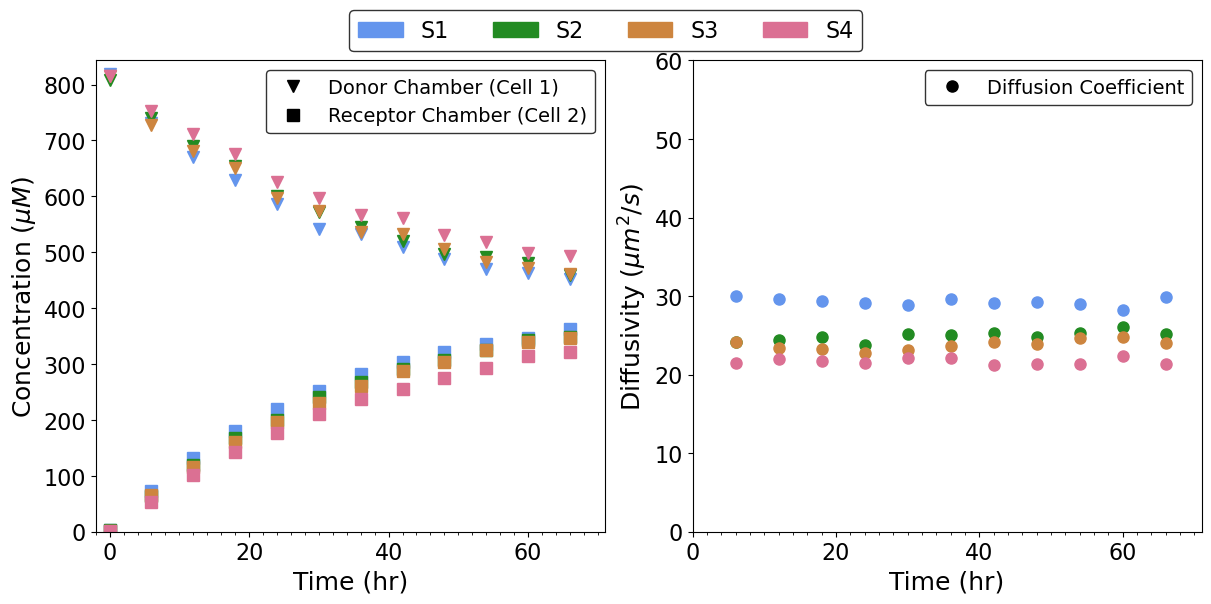

In [15]:
AD.progress_plots_4(full_df, sample_names=H_cells, max_time=max_t, max_D = 60, color_set=OG_suite, font=18)

### Total Concentration vs Time

Sum the concentrations in Cells 1 and 2 to keep track of total C (in case of partitioning/evaporation)

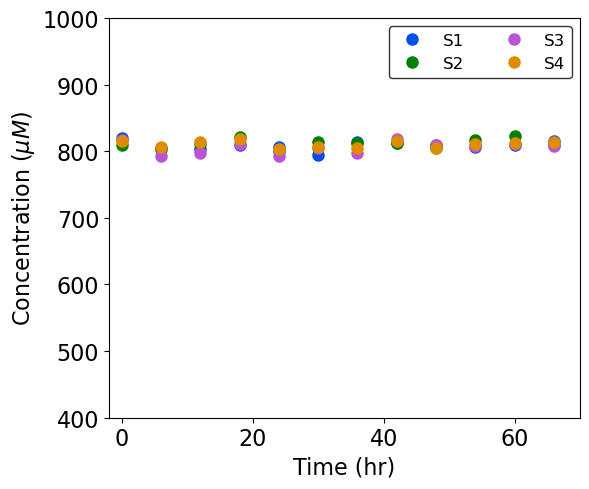

In [19]:
sum_df = pd.DataFrame(data=full_df)
sum_df['H1_sum'] = sum_df['H1_C1']+sum_df['H1_C2']
sum_df['H2_sum'] = sum_df['H2_C1']+sum_df['H2_C2']
sum_df['H3_sum'] = sum_df['H3_C1']+sum_df['H3_C2']
sum_df['H4_sum'] = sum_df['H4_C1']+sum_df['H4_C2']


fig, ax = plt.subplots(figsize=(6,5))

ax.plot(sum_df['Time'], sum_df['H1_sum'], label=H_cells['H1']['sample'], ms=8, marker='o',
        color=CB_suite[0], linewidth=0)
ax.plot(sum_df['Time'], sum_df['H2_sum'], label=H_cells['H2']['sample'], ms=8, marker='o',
        color=CB_suite[1], linewidth=0)
ax.plot(sum_df['Time'], sum_df['H3_sum'], label=H_cells['H3']['sample'], ms=8, marker='o',
        color=CB_suite[2], linewidth=0)
ax.plot(sum_df['Time'], sum_df['H4_sum'], label=H_cells['H4']['sample'], ms=8, marker='o',
        color=CB_suite[3], linewidth=0)
ax.set_xlabel('Time (hr)', fontsize=16)
ax.set_ylabel(r'Concentration ($\mu M$)', fontsize=16)
#ax.set_ylim(0,df['H1_C1'][0]+25)
ax.set_ylim(400,1000)
ax.set_xlim(-2,70)
ax.legend(loc='upper right', ncols=2, fontsize=12, edgecolor='inherit')
ax.tick_params(labelsize=16)

plt.tight_layout()
#plt.savefig('../Figures/'+ Date + 'fig_name.csv', dpi=300)
plt.show();

### Comparison Plot

Compare two (or more) samples from different experiments

In [ ]:
df1 = pd.read_csv('Results/20250603_manual_PES_P25G00_AO.csv')
df2 = pd.read_csv('Results/20250505_ot2_PES_P25G00_AO.csv')

fig2, (ax3,ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12,6), layout='constrained')
#fig2.suptitle('Manual vs Automated Sampling', fontsize=20)

donor = mlines.Line2D([], [], color='black', ls='', marker='v',
                          markersize=8, label='Donor Chamber (Cell 1)')
receptor = mlines.Line2D([], [], color='black', ls='', marker='s',
                          markersize=8, label='Receptor Chamber (Cell 2)')
diffusivity = mlines.Line2D([], [], color='black', ls='', marker='o',
                          markersize=8, label='Diffusion Coefficient')

sample_1 = mpatches.Patch(color='#332288', label='By Hand')
sample_2 = mpatches.Patch(color='#44AA99', label='Automated')


ax3.plot(df2['Time'], df2['H3_C1']/df2['H3_C1'][0], label='Automated (Cell 1)', ms=9, 
         marker='v', color='#44AA99', linewidth=0)
ax3.plot(df2['Time'], df2['H3_C2']/df2['H3_C1'][0], label='Automated (Cell 2)', ms=9, 
         marker='s', color='#44AA99', linewidth=0)
ax3.plot(df1['Time'], df1['H1_C1']/df1['H1_C1'][0], label='By Hand (Cell 1)',
         ms=9, marker='v', color='#332288', linewidth=0)
ax3.plot(df1['Time'], df1['H1_C2']/df1['H1_C1'][0], label='By Hand (Cell 2)',
         ms=9, marker='s', color='#332288', linewidth=0)

ax3.set_xlabel('Time (hr)', fontsize=18)
ax3.set_ylabel('RB Concentration (normalized)', fontsize=18)
ax3.set_ylim(0,1.1)
ax3.set_xlim(-2,70)
ax3.xaxis.set_minor_locator(MultipleLocator(2))
ax3.legend(handles=[donor, receptor], fontsize=14, edgecolor='inherit')
#ax3.legend(loc='upper right', ncols=1, fontsize=16, edgecolor='inherit')
ax3.tick_params(labelsize=18)


ax4.plot(df2['Time'], df2['S3'], label='Automated (P25G00)', ms=10, marker='o', color='#44AA99', linewidth=0)
ax4.plot(df1['Time'], df1['S1'], label='By Hand (P25G00)', ms=10, marker='o', color='#332288', linewidth=0)
ax4.set_xlabel('Time (hr)', fontsize=18)
ax4.set_ylabel('Diffusivity ($\mu m^2/s$)', fontsize=18)
ax4.set_ylim(0,60)
ax4.set_xlim(0,70)
ax4.xaxis.set_minor_locator(MultipleLocator(2))
ax4.legend(handles=[diffusivity], fontsize=14, edgecolor='inherit')
#ax4.legend(loc='upper right', ncols=1, fontsize=16, edgecolor='inherit')
ax4.tick_params(labelsize=18)

fig2.legend(handles=[sample_1, sample_2], loc='outside lower center', ncols=4,
           fontsize=16, edgecolor='inherit')

#plt.savefig('../Figures/'+ Date + 'fig_name.csv', dpi=300)
plt.show();